# KNN Modeling

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import ceil
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_recall_fscore_support, make_scorer, fbeta_score, RocCurveDisplay, DetCurveDisplay, ConfusionMatrixDisplay
from sklearn.decomposition import PCA
from scipy.spatial import distance 

np.random.seed(1000)

## Load Data

In [48]:
def read_dataset(name):
  df_train = pd.read_csv(f"../data/modeling/data_{name}_train.csv")
  df_test = pd.read_csv(f"../data/modeling/data_{name}_test.csv")

  X_train = df_train.drop(columns="Abnormal")
  X_test = df_test.drop(columns="Abnormal")
  y_train = df_train.Abnormal
  y_test = df_test.Abnormal

  return X_train, X_test, y_train, y_test

X_1da_train, X_1da_test, y_train, y_test = read_dataset("1da")
X_reduced_train, X_reduced_test, _, _ = read_dataset("reduced")
X_expanded_train, X_expanded_test, _, _ = read_dataset("expanded")

## Model Configuration

In [49]:
train_features = {
  "knn_1da": X_1da_train,
  "knn_red": X_reduced_train,
  "knn_exp": X_expanded_train,
  "knn_pca_1da": X_1da_train,
  "knn_pca_red": X_reduced_train,
  "knn_pca_exp": X_expanded_train,
}

test_features = {
  "knn_1da": X_1da_test,
  "knn_red": X_reduced_test,
  "knn_exp": X_expanded_test,
  "knn_pca_1da": X_1da_test,
  "knn_pca_red": X_reduced_test,
  "knn_pca_exp": X_expanded_test,
}

def make_knn_config(max_n_neighbors, max_n_components=None):
  config = {
    "clf": KNeighborsClassifier(n_jobs=-1),
    "param_grid": {
      "clf__n_neighbors": [max_n_neighbors if max_n_neighbors & 1 else max_n_neighbors + 1],
      "clf__weights": ["uniform", "distance"],
      "clf__p": [1, 2]
    }
  }
  if max_n_components is not None:
    config["param_grid"]["pca__n_components"] = [x for x in range(1, max_n_components+1)]
  return config

model_configs = {
  "knn_1da": make_knn_config(ceil(X_1da_train.shape[0]**0.5)),
  "knn_red": make_knn_config(ceil(X_reduced_train.shape[0]**0.5)),
  "knn_exp": make_knn_config(ceil(X_expanded_train.shape[0]**0.5)),
  "knn_pca_1da": make_knn_config(ceil(X_1da_train.shape[0]**0.5), X_1da_train.shape[1]),
  "knn_pca_red": make_knn_config(ceil(X_reduced_train.shape[0]**0.5), X_reduced_train.shape[1]),
  "knn_pca_exp": make_knn_config(ceil(X_expanded_train.shape[0]**0.5), X_expanded_train.shape[1])
}

## Training

In [50]:
def perform_grid_search_fit(model_config, X_fit, y_fit):
  clf = model_config["clf"]
  param_grid = model_config["param_grid"]

  pipe_steps = [
    ("scaler", StandardScaler()),
    ("clf", clf)
  ]

  if "pca" in name:
    pipe_steps.insert(1, ("pca", PCA()))

  pipe = Pipeline(pipe_steps)
  kf = StratifiedKFold(n_splits=10)
  search = GridSearchCV(pipe, param_grid, cv=kf, scoring=make_scorer(fbeta_score, beta=2), n_jobs=-1, refit=True)
  search.fit(X_fit, y_fit)

  return (search.best_estimator_, search.best_params_)

best_models = {}
for name, model_config in model_configs.items():
  X_train = train_features[name]
  best_model, best_params = perform_grid_search_fit(model_config, X_train, y_train)
  print(f"Best params for model {name}: {best_params}")
  best_models[name] = {
    "model": best_model,
    "params": best_params
  }

Best params for model knn_1da: {'clf__n_neighbors': 61, 'clf__p': 1, 'clf__weights': 'distance'}
Best params for model knn_red: {'clf__n_neighbors': 61, 'clf__p': 1, 'clf__weights': 'distance'}
Best params for model knn_exp: {'clf__n_neighbors': 61, 'clf__p': 1, 'clf__weights': 'distance'}
Best params for model knn_pca_1da: {'clf__n_neighbors': 61, 'clf__p': 2, 'clf__weights': 'distance', 'pca__n_components': 7}
Best params for model knn_pca_red: {'clf__n_neighbors': 61, 'clf__p': 2, 'clf__weights': 'distance', 'pca__n_components': 7}
Best params for model knn_pca_exp: {'clf__n_neighbors': 61, 'clf__p': 1, 'clf__weights': 'distance', 'pca__n_components': 7}


## Threshold Selection

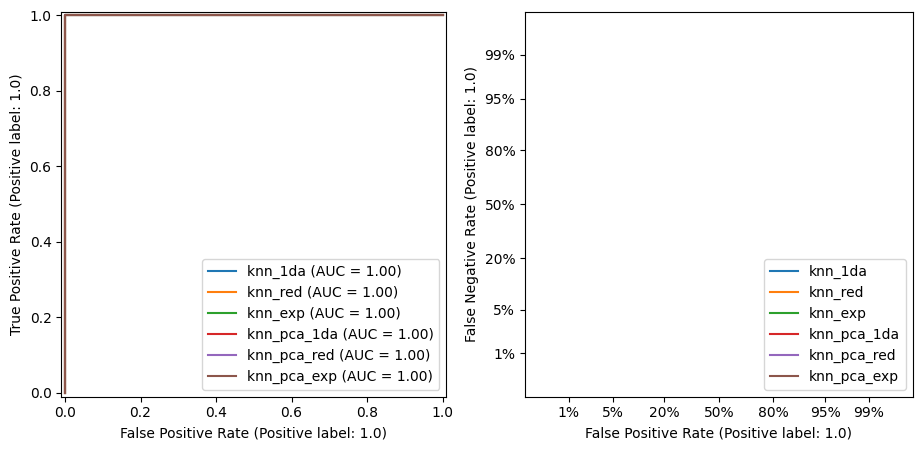

In [51]:
fig, [ax_roc, ax_det] = plt.subplots(1, 2, figsize=(11, 5))

for name, best_model in best_models.items():
  mod = best_model["model"]
  params = best_model["params"]
  X_train = train_features[name]
 
  RocCurveDisplay.from_estimator(mod, X_train, y_train, ax=ax_roc, name=name)
  DetCurveDisplay.from_estimator(mod, X_train, y_train, ax=ax_det, name=name)

In [52]:
mod_thresh = {}
for name, best_model in best_models.items():
  mod = best_model["model"]
  X_train = train_features[name]
  y_prob = mod.predict_proba(X_train)[:,1]
  
  t_iter = []
  f2_iter = []

  thres = [round(x/1000,5) for x in np.geomspace(1, 500, 101)]
  opt_thres = -1
  max_f2 = -1
  for t in thres:
    pred_y = [0 if p < t else 1 for p in y_prob]
    prec, rec, f2, _ = precision_recall_fscore_support(y_train, pred_y, beta=2, average="binary", zero_division=0)
    if f2 > max_f2: 
      max_f2 = f2
      opt_thres = t
      
  print(f"{name} - Opt thresh: {opt_thres}")
  mod_thresh[name] = opt_thres

knn_1da - Opt thresh: 0.001
knn_red - Opt thresh: 0.001
knn_exp - Opt thresh: 0.001
knn_pca_1da - Opt thresh: 0.001
knn_pca_red - Opt thresh: 0.001
knn_pca_exp - Opt thresh: 0.001


## Test Evaluation

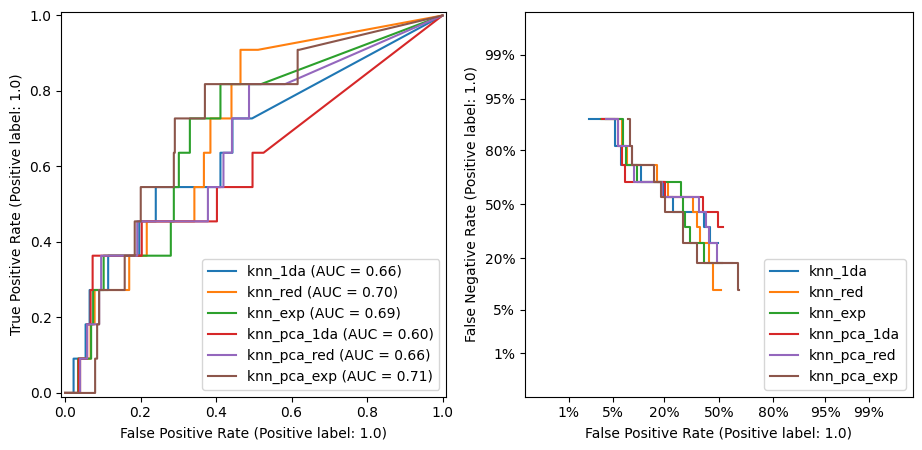

In [53]:
fig, [ax_roc, ax_det] = plt.subplots(1, 2, figsize=(11, 5))

for name, best_model in best_models.items():
  mod = best_model["model"]
  params = best_model["params"]
  X_test = test_features[name]
 
  RocCurveDisplay.from_estimator(mod, X_test, y_test, ax=ax_roc, name=name)
  DetCurveDisplay.from_estimator(mod, X_test, y_test, ax=ax_det, name=name)

knn_1da - precision: 0.021, recall: 0.7273, f2: 0.09412
knn_red - precision: 0.02532, recall: 0.9091, f2: 0.1139
knn_exp - precision: 0.0225, recall: 0.8182, f2: 0.1014
knn_pca_1da - precision: 0.01737, recall: 0.6364, f2: 0.0783
knn_pca_red - precision: 0.02009, recall: 0.8182, f2: 0.09146
knn_pca_exp - precision: 0.02096, recall: 0.9091, f2: 0.09597


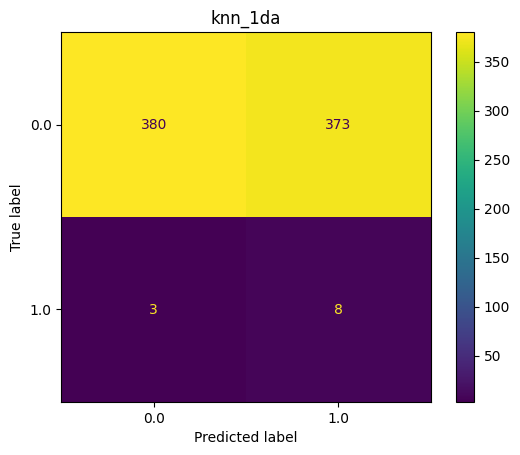

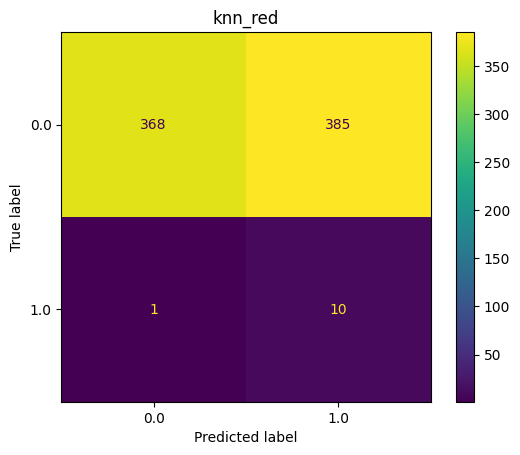

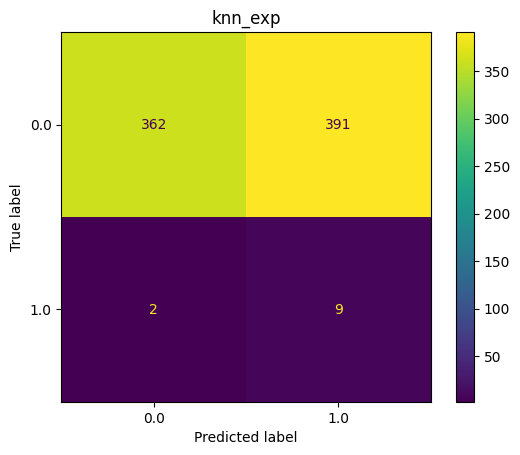

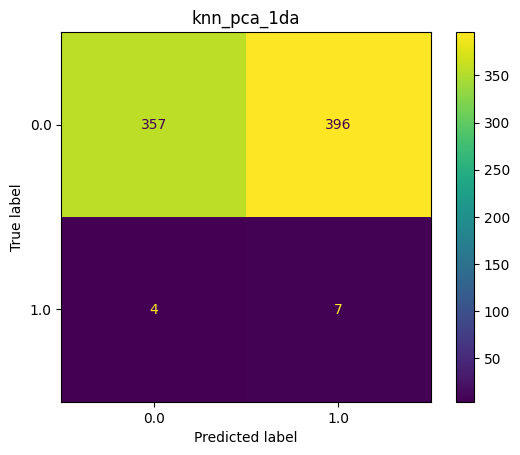

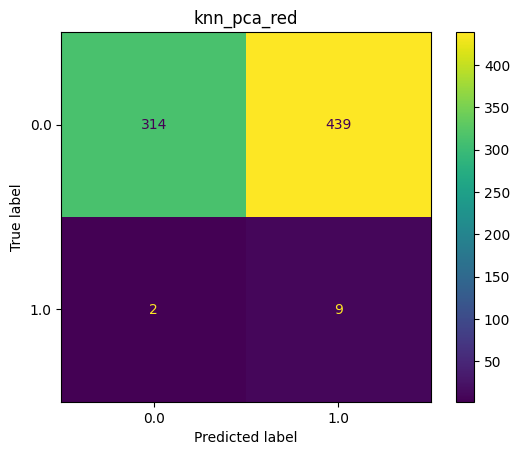

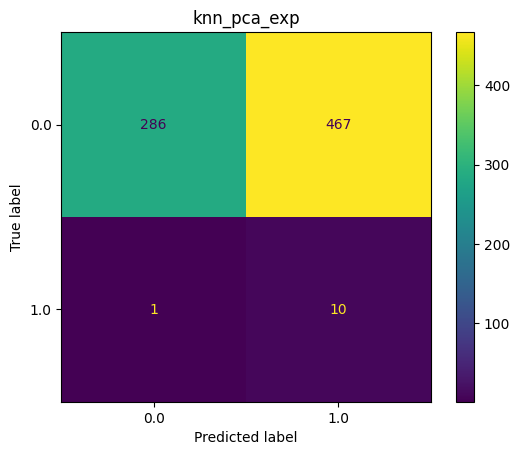

In [54]:
for name, best_model in best_models.items():
  mod = best_model["model"]
  X_test = test_features[name]

  test_prob = mod.predict_proba(X_test)[:,1]
  test_pred = [0 if p < mod_thresh[name] else 1 for p in test_prob]

  p, r, f2, supp = precision_recall_fscore_support(y_test, test_pred, average="binary", beta=2, pos_label=1.0, zero_division=0)
  print(f"{name} - precision: {p:.4}, recall: {r:.4}, f2: {f2:.4}")

  disp = ConfusionMatrixDisplay.from_predictions(y_test, test_pred)
  disp.ax_.set_title(name)